# Business Analysis on Movie Production

> ## Prediction of a Successful Movie

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
## fixing random for lesson generation
np.random.seed(321)

##import statsmodels correctly
import statsmodels.api as sm

In [2]:
#pd.set_option('display.max_columns',100)

In [3]:
df =pd.read_csv(r"Movies_files\tmdb_combined_years.csv.gz")#, lineterminator ="\n")

In [4]:
# remove ids that are 0
df = df.loc[ df['imdb_id']!='0']

In [5]:
df = df.reset_index(drop=True)
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.wkw-inthemoodforlove.com/,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.1,1860.0,PG
1,tt0120467,0.0,NaN,NaN,120000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",NaN,19085.0,en,Vulgar,...,14904.0,87.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Everyone loves a clown... some more than others.,Vulgar,0.0,5.5,40.0,R
2,tt0120630,0.0,/t7aJ7hqsMLEoqBJk7yAXxcAVvcz.jpg,"{'id': 718551, 'name': 'Chicken Run Collection...",45000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",NaN,7443.0,en,Chicken Run,...,224834564.0,84.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,This ain't no chick flick. It's poultry in mot...,Chicken Run,0.0,6.7,3992.0,G
3,tt0120753,0.0,/cXXxi0j9sXFt7LbeajuFoKFqWMu.jpg,NaN,8000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,318.0,en,The Million Dollar Hotel,...,105983.0,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Everyone has something to hide.,The Million Dollar Hotel,0.0,5.9,247.0,R
4,tt0120755,0.0,/8XaohdSqoBEWHhW40q2VTdMBrV0.jpg,"{'id': 87359, 'name': 'Mission: Impossible Col...",125000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",NaN,955.0,en,Mission: Impossible II,...,546388105.0,123.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Expect the impossible again.,Mission: Impossible II,0.0,6.1,5266.0,PG-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5073,tt9639470,0.0,/7OcRErUXXdAVAHg6y5cjn56ivtu.jpg,NaN,43000000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 27, 'n...",https://www.focusfeatures.com/last-night-in-soho,576845.0,en,Last Night in Soho,...,22957625.0,117.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"When the past lets you in, the truth will come...",Last Night in Soho,0.0,7.5,1574.0,R
5074,tt9664108,0.0,/9dBSwftCzkC4K4zgMZTwcm58VUR.jpg,NaN,20000000.0,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",https://www.voyagers.movie,597890.0,en,Voyagers,...,4284903.0,108.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,What does it feel like?,Voyagers,0.0,6.1,509.0,PG-13
5075,tt9784798,0.0,/fatz1aegtBGh7KS0gipcsw9MqUn.jpg,NaN,26000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",https://www.judasandtheblackmessiah.com,583406.0,en,Judas and the Black Messiah,...,6416063.0,126.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,You can kill a revolutionary but you can't kil...,Judas and the Black Messiah,0.0,7.4,1011.0,NaN
5076,tt9844322,0.0,/AsKrGC7Y5J5k4BFbY9Upp09vJsH.jpg,NaN,17516235.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,577242.0,fr,Kaamelott - Premier volet,...,19002036.0,120.0,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,Patience is better served with sauce,Kaamelott: The First Chapter,0.0,6.9,455.0,NaN


## Preprocessing

In [6]:
## Save only Released status
df = df.loc[ df['status'] == 'Released']
## Columns to exclude
drop_cols = ['backdrop_path','backdrop_path','original_title','overview',
                 'poster_path','tagline','id','homepage', 'status',
                 'production_countries','video','spoken_languages',
            'original_language']
df = df.drop(columns=drop_cols)


## Feature Engineering
>- #### Collection: convert to boolean
>- #### Genres: get just name and manually OHE
>- #### Cleaning Categories in Certification
>- #### Converting release date to year, month, and day.

>- Keeping only movies with status =Released

>- Keeping only movies with budget and Revenue greater than 0

### belongs to collection

In [7]:
# there are 1,117+ movies that belong to collections
df['belongs_to_collection'].notna().sum()

1117

In [8]:
## Use .notna() to get True if it belongs to a collection
df['belongs_to_collection'] = df['belongs_to_collection'].notna()
df['belongs_to_collection'].value_counts()

False    3961
True     1117
Name: belongs_to_collection, dtype: int64

### Genre

In [9]:
## Function to get just the genre names as a list 
import json
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [10]:
## Use ourn function and exploding the new column
df['genres_list'] = df['genres'].apply(get_genre_name)
df_explode = df.explode('genres_list')
df_explode

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification,genres_list
0,tt0118694,0.0,False,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",15.533,"[{'id': 539, 'logo_path': None, 'name': 'Block...",2000-09-29,12854953.0,99.0,In the Mood for Love,8.1,1860.0,PG,Drama
0,tt0118694,0.0,False,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",15.533,"[{'id': 539, 'logo_path': None, 'name': 'Block...",2000-09-29,12854953.0,99.0,In the Mood for Love,8.1,1860.0,PG,Romance
1,tt0120467,0.0,False,120000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",5.435,"[{'id': 102045, 'logo_path': None, 'name': 'Ch...",2002-04-26,14904.0,87.0,Vulgar,5.5,40.0,R,Drama
1,tt0120467,0.0,False,120000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",5.435,"[{'id': 102045, 'logo_path': None, 'name': 'Ch...",2002-04-26,14904.0,87.0,Vulgar,5.5,40.0,R,Horror
1,tt0120467,0.0,False,120000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",5.435,"[{'id': 102045, 'logo_path': None, 'name': 'Ch...",2002-04-26,14904.0,87.0,Vulgar,5.5,40.0,R,Thriller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5076,tt9844322,0.0,False,17516235.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",14.901,"[{'id': 2902, 'logo_path': '/nSPZ1BNASeC2dxJKB...",2021-07-21,19002036.0,120.0,Kaamelott: The First Chapter,6.9,455.0,NaN,Fantasy
5076,tt9844322,0.0,False,17516235.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",14.901,"[{'id': 2902, 'logo_path': '/nSPZ1BNASeC2dxJKB...",2021-07-21,19002036.0,120.0,Kaamelott: The First Chapter,6.9,455.0,NaN,Comedy
5077,tt9844522,0.0,True,15000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",134.478,"[{'id': 333, 'logo_path': '/5xUJfzPZ8jWJUDzYtI...",2021-07-01,44888959.0,88.0,Escape Room: Tournament of Champions,6.7,1130.0,PG-13,Horror
5077,tt9844522,0.0,True,15000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",134.478,"[{'id': 333, 'logo_path': '/5xUJfzPZ8jWJUDzYtI...",2021-07-01,44888959.0,88.0,Escape Room: Tournament of Champions,6.7,1130.0,PG-13,Thriller


In [11]:
## save unique genres
unique_genres = df_explode['genres_list'].dropna().unique()

In [12]:
## Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex=False)

In [13]:
## Drop original genre cols
df = df.drop(columns=['genres','genres_list'])
df.head()

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,release_date,revenue,runtime,title,...,Genre_Adventure,Genre_Action,Genre_Science Fiction,Genre_Fantasy,Genre_Mystery,Genre_War,Genre_Music,Genre_History,Genre_Western,Genre_Documentary
0,tt0118694,0.0,False,150000.0,15.533,"[{'id': 539, 'logo_path': None, 'name': 'Block...",2000-09-29,12854953.0,99.0,In the Mood for Love,...,False,False,False,False,False,False,False,False,False,False
1,tt0120467,0.0,False,120000.0,5.435,"[{'id': 102045, 'logo_path': None, 'name': 'Ch...",2002-04-26,14904.0,87.0,Vulgar,...,False,False,False,False,False,False,False,False,False,False
2,tt0120630,0.0,True,45000000.0,40.520,"[{'id': 521, 'logo_path': '/kP7t6RwGz2AvvTkvnI...",2000-06-21,224834564.0,84.0,Chicken Run,...,False,False,False,False,False,False,False,False,False,False
3,tt0120753,0.0,False,8000000.0,8.453,"[{'id': 1490, 'logo_path': None, 'name': 'Kint...",2000-02-09,105983.0,122.0,The Million Dollar Hotel,...,False,False,False,False,False,False,False,False,False,False
4,tt0120755,0.0,True,125000000.0,25.160,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...",2000-05-24,546388105.0,123.0,Mission: Impossible II,...,True,True,False,False,False,False,False,False,False,False


### Certification

In [14]:
## Checking Certification values
df['certification'].value_counts(dropna=False)

R        1705
PG-13    1446
NaN      1155
PG        523
NR        145
G          89
NC-17      15
Name: certification, dtype: int64

In [15]:
# fix extra space certs
df['certification'] = df['certification'].str.strip()

In [16]:
## fix certification col
repl_cert = {'PG':'PG-13',
             'nan':'np.nan',
             'G':'PG-13'}
             
df['certification'] = df['certification'].replace(repl_cert)
df['certification'].value_counts(dropna=False)

PG-13    2058
R        1705
NaN      1155
NR        145
NC-17      15
Name: certification, dtype: int64

In [17]:
df['certification'].unique()

array(['PG-13', 'R', nan, 'NR', 'NC-17'], dtype=object)

#### Converting year to sep features

In [18]:
## split release date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-',expand=True)

df[new_cols] = df[new_cols].astype(float)

In [19]:
## drop original feature
df = df.drop(columns=['release_date'])

### Production Company

In [20]:
df['production_companies']

0       [{'id': 539, 'logo_path': None, 'name': 'Block...
1       [{'id': 102045, 'logo_path': None, 'name': 'Ch...
2       [{'id': 521, 'logo_path': '/kP7t6RwGz2AvvTkvnI...
3       [{'id': 1490, 'logo_path': None, 'name': 'Kint...
4       [{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...
                              ...                        
5073    [{'id': 10146, 'logo_path': '/xnFIOeq5cKw09kCW...
5074    [{'id': 148185, 'logo_path': None, 'name': 'No...
5075    [{'id': 79426, 'logo_path': '/8aEC7xem9YwHNCDo...
5076    [{'id': 2902, 'logo_path': '/nSPZ1BNASeC2dxJKB...
5077    [{'id': 333, 'logo_path': '/5xUJfzPZ8jWJUDzYtI...
Name: production_companies, Length: 5078, dtype: object

In [21]:
## getting longest string to check for multiple companies
idxmax = df['production_companies'].apply(len).idxmax()
idxmax 

43

In [22]:
test = df.loc[idxmax, 'production_companies']
test

"[{'id': 53671, 'logo_path': None, 'name': 'Lantia Cinema & Audiovisivi', 'origin_country': ''}, {'id': 8, 'logo_path': '/78ilmDNTpdCfsakrsLqmAUkFTrO.png', 'name': 'Fine Line Features', 'origin_country': ''}, {'id': 76, 'logo_path': '/nebkQYtQKhZyHJfh5v0oGpNbPzu.png', 'name': 'Zentropa Entertainments', 'origin_country': 'DK'}, {'id': 119, 'logo_path': '/1di2gITGUZr730AMuMKiCrP90Vl.png', 'name': 'DR', 'origin_country': 'DK'}, {'id': 157, 'logo_path': None, 'name': 'SVT Drama', 'origin_country': ''}, {'id': 201, 'logo_path': '/6UIpEURdjnmcJPwgTDRzVRuwADr.png', 'name': 'ARTE', 'origin_country': 'FR'}, {'id': 321, 'logo_path': '/pfp6VWF3tYfOHHVRHpYe2iGcYrf.png', 'name': 'Memfis Film', 'origin_country': 'SE'}, {'id': 591, 'logo_path': '/q5I5RDwMEiqoNmfaJgd2LraEOJY.png', 'name': 'France 3 Cinéma', 'origin_country': 'FR'}, {'id': 2996, 'logo_path': None, 'name': 'Angel films', 'origin_country': ''}, {'id': 5975, 'logo_path': '/vvjgoKygWWYZvYyidT3RmOCq5If.png', 'name': 'YLE', 'origin_country':

In [23]:
# using regular expressions to extrap just the name
import re
exp= r"\'name\'\:.?\'(\w*.*?)\'"
re.findall(exp, test)

['Lantia Cinema & Audiovisivi',
 'Fine Line Features',
 'Zentropa Entertainments',
 'DR',
 'SVT Drama',
 'ARTE',
 'Memfis Film',
 'France 3 Cinéma',
 'Angel films',
 'YLE',
 'Blind Spot Pictures',
 'VPRO',
 'Liberator Productions',
 'Íslenska kvikmyndasamsteypan',
 'Pain Unlimited GmbH Filmproduktion',
 'Trust Film Svenska',
 'Cinematograph A/S',
 'What Else? B.V',
 'Filmek A/S',
 'Film4 Productions',
 'Canal+',
 'ARTE France Cinéma',
 'Film i Väst',
 'TV 1000 Sverige',
 'WDR',
 'Constantin Film']

In [24]:
def get_prod_company_names(x):
    if x=='[]':
        return ["MISSING"]
    
    exp= r"\'name\'\:.?\'(\w*.*?)\'"
    companies = re.findall(exp, x)
    return companies

In [25]:
## test function
get_prod_company_names(test)

['Lantia Cinema & Audiovisivi',
 'Fine Line Features',
 'Zentropa Entertainments',
 'DR',
 'SVT Drama',
 'ARTE',
 'Memfis Film',
 'France 3 Cinéma',
 'Angel films',
 'YLE',
 'Blind Spot Pictures',
 'VPRO',
 'Liberator Productions',
 'Íslenska kvikmyndasamsteypan',
 'Pain Unlimited GmbH Filmproduktion',
 'Trust Film Svenska',
 'Cinematograph A/S',
 'What Else? B.V',
 'Filmek A/S',
 'Film4 Productions',
 'Canal+',
 'ARTE France Cinéma',
 'Film i Väst',
 'TV 1000 Sverige',
 'WDR',
 'Constantin Film']

In [26]:
## Save new clean prod_comapny col and explode
df['prod_company'] = df['production_companies'].apply(get_prod_company_names)
prod_companies = df['prod_company'].explode()
prod_companies.value_counts().head(49)

Universal Pictures           287
Warner Bros. Pictures        281
Columbia Pictures            234
20th Century Fox             194
Paramount                    178
MISSING                      166
Canal+                       151
New Line Cinema              143
Walt Disney Pictures         135
Relativity Media             123
Lionsgate                    120
DreamWorks Pictures           99
Metro-Goldwyn-Mayer           98
StudioCanal                   96
Village Roadshow Pictures     91
Touchstone Pictures           76
Miramax                       74
Summit Entertainment          72
Dune Entertainment            72
Screen Gems                   69
TSG Entertainment             67
Focus Features                66
Fox Searchlight Pictures      64
Sony Pictures                 62
Regency Enterprises           62
Working Title Films           56
Dimension Films               55
Blumhouse Productions         55
Legendary Pictures            51
Millennium Films              50
The Weinst

 Common Prod Company Encoding:

>- Keep top 50 most common companies an one hot encode

In [27]:
## saving the 50 most common companies
common_companies = sorted(prod_companies.value_counts().head(50).index)
common_companies

['20th Century Fox',
 'BBC Films',
 'Blumhouse Productions',
 'CJ Entertainment',
 'Canal+',
 'Ciné+',
 'Columbia Pictures',
 'Dimension Films',
 'DreamWorks Animation',
 'DreamWorks Pictures',
 'Dune Entertainment',
 'Epsilon Motion Pictures',
 'EuropaCorp',
 'Film4 Productions',
 'Focus Features',
 'Fox 2000 Pictures',
 'Fox Searchlight Pictures',
 'France 2 Cinéma',
 'France 3 Cinéma',
 'Ingenious Media',
 'Legendary Pictures',
 'Lionsgate',
 'MISSING',
 'Metro-Goldwyn-Mayer',
 'Millennium Films',
 'Miramax',
 'New Line Cinema',
 'New Regency Pictures',
 'Original Film',
 'Paramount',
 'Participant',
 'Regency Enterprises',
 'Relativity Media',
 'Revolution Studios',
 'Scott Free Productions',
 'Scott Rudin Productions',
 'Screen Gems',
 'Sony Pictures',
 'Spyglass Entertainment',
 'StudioCanal',
 'Summit Entertainment',
 'TF1 Films Production',
 'TSG Entertainment',
 'The Weinstein Company',
 'Touchstone Pictures',
 'Universal Pictures',
 'Village Roadshow Pictures',
 'Walt Disney 

In [28]:
## manually ohe top 20 companies
for company in common_companies:
    df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex =False)

# Base Model

### Train Test Split

In [29]:
## Dropping columns
drop_cols = ['revenue','title','imdb_id','prod_company','production_companies']

In [30]:
## Make x and y variables
y = df["revenue"]
X = df.drop(columns =drop_cols)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y)#, random_state=321)

In [32]:
## make cat selector and using it to save list of column names
cat_select = make_column_selector(dtype_include='object')
cat_cols = cat_select(X_train)

In [33]:
## make num selector and using it to save list of column names
num_select = make_column_selector(dtype_include='number')
num_cols = num_select(X_train)

In [34]:
## select manually OHE cols for later
bool_select = make_column_selector(dtype_include='bool')
already_ohe_cols = bool_select(X_train)

In [35]:
## convert manual ohe to int
X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

In [36]:
## make pipelines
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                           fill_value='MISSING'),
                             OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())

In [37]:
preprocessor = make_column_transformer((num_pipe, num_cols),
                                           (cat_pipe,cat_cols),remainder='passthrough')

## fit the col transformer
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['adult', 'budget', 'popularity', 'runtime',
                                  'vote_average', 'vote_count', 'year', 'month',
                                  'day']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='

In [38]:
## Finding the categorical pipeline in our col transformer.
preprocessor.named_transformers_['pipeline-2']

## B) Using list-slicing to find the encoder 
cat_features = preprocessor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)

In [39]:
## Create the empty list
final_features = [*num_cols,*cat_features,*already_ohe_cols]
len(final_features)

preprocessor.transform(X_train).shape

(3808, 83)

In [40]:
X_train_tf = pd.DataFrame( preprocessor.transform(X_train), 
                              columns=final_features, index=X_train.index)


X_test_tf = pd.DataFrame( preprocessor.transform(X_test),
                             columns=final_features, index=X_test.index)

In [41]:
### Adding a Constant for Statsmodels

##import statsmodels correctly
import statsmodels.api as sm

#> Tip: make sure that add_constant actually added a new column! You may need to change the parameter has_constant to "add"

## Make final X_train_df and X_test_df with constants added
X_train_df = sm.add_constant(X_train_tf, prepend=False, has_constant='add')
X_test_df = sm.add_constant(X_test_tf, prepend=False, has_constant='add')

display(X_train_df.head(2),X_test_df.head(2))

,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_MISSING,...,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Working Title Films,const
194,0.0,-0.428401,-0.198733,-1.098740,-0.522937,-0.558007,-1.674082,-1.393872,-1.550172,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3351,0.0,0.718546,-0.120727,1.317234,1.040945,0.507334,0.600949,1.499559,1.130364,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_MISSING,...,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Working Title Films,const
582,0.0,-0.574580,-0.212386,-0.435532,-0.088525,-0.596123,-1.324078,-1.104529,0.081459,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1658,0.0,-0.738414,0.178416,-1.146112,-0.262290,0.708808,-0.624068,0.631529,-0.151631,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [42]:
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     156.1
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:18:59   Log-Likelihood:                -75262.
No. Observations:                3808   AIC:                         1.507e+05
Df Residuals:                    3727   BIC:                         1.512e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
adult                               1.481e-09   5.23e-10      2.830      0.005    4.55e-10    2.51e-09
budget                              8.227e+07   2.65e+06     31.023      0.000    7.71e+07    8.75e+07
popularity                          1.811e+07   1.63e+06     11.117      0.000    1.49e+07    2.13e+07
runtime                             5.182e+06   1.85e+06      2.805      0.005    1.56e+06     8.8e+06
vote_average                       -4.988e+06   1.74e+06     -2.868      0.004    -8.4e+06   -1.58e+06
vote_count                          9.904e+07   2.28e+06     43.501      0.000    9.46e+07    1.04e+08
year                                8.892e+05    1.7e+06      0.524      0.600   -2.44e+06    4.21e+06
month                              -1.123e+05   1.55e+06     -0.072      0.942   -3.16e+06    2.94e+06
day                                 6.091e+05   1.54e+06      0.395      0.693   -2.41e+06    3.63e+06
certification_MISSING               3.322e+07   6.21e+06      5.351      0.000     2.1e+07    4.54e+07
certification_NC-17                 9.579e+06   2.63e+07      0.364      0.716    -4.2e+07    6.11e+07
certification_NR                    2.241e+07    9.3e+06      2.411      0.016    4.18e+06    4.06e+07
certification_PG-13                 1.954e+07   6.21e+06      3.145      0.002    7.36e+06    3.17e+07
certification_R                     9.849e+05   6.09e+06      0.162      0.872    -1.1e+07    1.29e+07
belongs_to_collection               4.849e+07   4.18e+06     11.606      0.000    4.03e+07    5.67e+07
Genre_Drama                        -1.124e+06      4e+06     -0.281      0.779   -8.97e+06    6.73e+06
Genre_Romance                       6.348e+06   4.42e+06      1.437      0.151   -2.31e+06     1.5e+07
Genre_Horror                        1.596e+06   5.91e+06      0.270      0.787   -9.99e+06    1.32e+07
Genre_Thriller                      -5.25e+06   4.28e+06     -1.227      0.220   -1.36e+07    3.14e+06
Genre_Crime                        -4.701e+06   4.94e+06     -0.952      0.341   -1.44e+07    4.98e+06
Genre_Animation                     9.198e+06   8.32e+06      1.105      0.269   -7.12e+06    2.55e+07
Genre_Comedy                        1.981e+06   3.99e+06      0.496      0.620   -5.85e+06    9.81e+06
Genre_Family                       -5.424e+06   6.97e+06     -0.779      0.436   -1.91e+07    8.23e+06
Genre_Adventure                      7.77e+06   5.13e+06      1.515      0.130   -2.29e+06    1.78e+07
Genre_Action                       -1.055e+07   4.29e+06     -2.463      0.014    -1.9e+07   -2.15e+06
Genre_Science Fiction              -3.551e+07   5.76e+06     -6.167      0.000   -4.68e+07   -2.42e+07
Genre_Fantasy                      -1.509e+07    5.6e+06     -2.695      0.007   -2.61e+07   -4.

In [43]:
print ('_______________________________________________')
## Get train data performance from skearn to confirm matches OLS
y_hat_train = result.predict(X_train_df)
print(f'Sklearn version| Training R^2: {r2_score(y_train, y_hat_train):.3f}')

## Get test data performance
y_hat_test = result.predict(X_test_df)
print(f'Sklearn version| Testing  R^2: {r2_score(y_test, y_hat_test):.3f}')

_______________________________________________
Sklearn version| Training R^2: 0.770
Sklearn version| Testing  R^2: 0.737


## The Assumptions of Linear Regression

The 4 Assumptions of a Linear Regression are:

>- Normality: The model's residuals are approximately normally distributed.

>- Homoscedasticity: The model residuals have equal variance across all predictions.

>- Linearity: That the input features have a linear relationship with the target.

>- Independence of features (AKA Little-to-No Multicollinearity): That the features are not strongly related to other features.

## Normality and Homoscedasticity
 >- QQ Plot for checking Normality 
 >- Residual Plot for Checking Homoscedasticity

#### A function to plot QQ plot and Residual plot on same graph

In [44]:
def evaluate_ols(result,X_train_df, y_train, show_summary=True):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    """
    #try:
        #display(result.summary())
    #except:
       # pass
    
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()

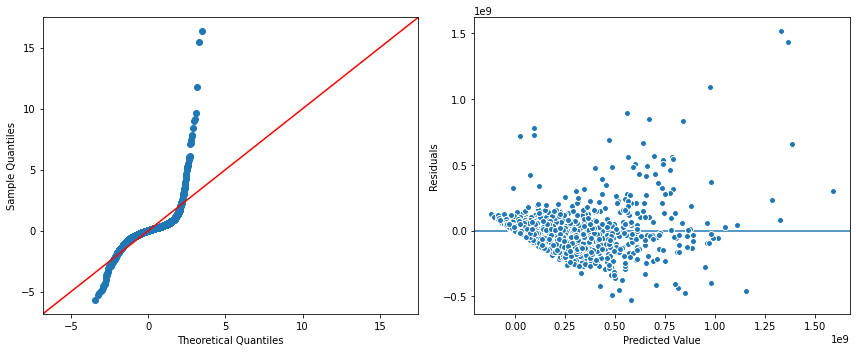

In [45]:
    
evaluate_ols(result,X_train_df, y_train)

#### Removing Outliers to improve model

#### Using Z-Score Rule

In [46]:
#Saving numeric columns that could contain outliers into a variable
outlier_cols = df[["budget", "popularity", "runtime", "vote_average", 'vote_count']]

(<matplotlib.axes._subplots.AxesSubplot at 0x1ab6285f408>,)

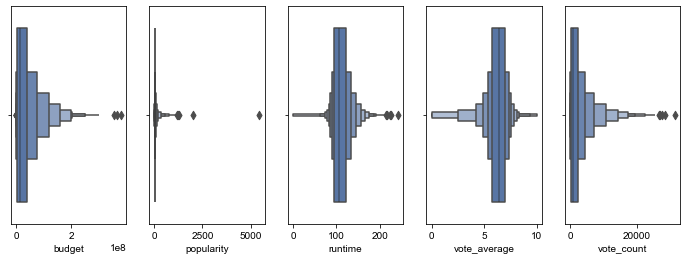

In [47]:
#### Use of boxplots to view columns with outliers

plt.rcParams["figure.figsize"] = [12, 4]
f, axes =plt.subplots(nrows = 1, ncols = 5)
sns.set_theme(style="whitegrid")
sns.boxenplot(ax = axes[0], x=df["budget"])
sns.boxenplot(ax = axes[1], x=df["popularity"])
sns.boxenplot(ax = axes[2], x=df["runtime"])
sns.boxenplot(ax = axes[3], x=df["vote_average"])
sns.boxenplot(ax = axes[4], x=df["vote_count"]),

In [48]:
#Checking for outliers in columns
from scipy import stats
outliers = np.abs(stats.zscore(outlier_cols))>3
print(f"{outliers.sum()} outliers found in using Z-Scores.")

budget          141
popularity       44
runtime           0
vote_average    102
vote_count      132
dtype: int64 outliers found in using Z-Scores.


In [49]:
#Original shape of data before removal of outliers
print(f'shape before removal of outliers{df.shape}')

shape before removal of outliers(5078, 84)


In [50]:
#def remove_outliers(df,columns,n_std):
for col in outlier_cols:
              
    mean = df[col].mean()
    sd = df[col].std()

    df = df[(df[col] <= mean+(3*sd))]

print (f'shape after removal of outliers: {df.shape}')

shape after removal of outliers: (4697, 84)


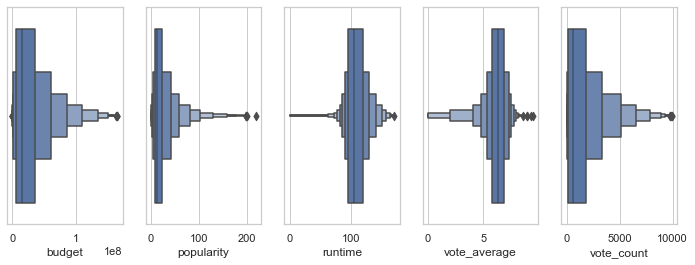

In [51]:
## visualzie outlier-removed columns
plt.rcParams["figure.figsize"] = [12, 4]
f, axes =plt.subplots(nrows = 1, ncols = 5)
sns.set_theme(style="whitegrid")
sns.boxenplot(ax = axes[0], x=df["budget"])
sns.boxenplot(ax = axes[1], x=df["popularity"])
sns.boxenplot(ax = axes[2], x=df["runtime"])
sns.boxenplot(ax = axes[3], x=df["vote_average"])
sns.boxenplot(ax = axes[4], x=df["vote_count"]);
    

In [52]:
### Checking for improved normality and hemodascity

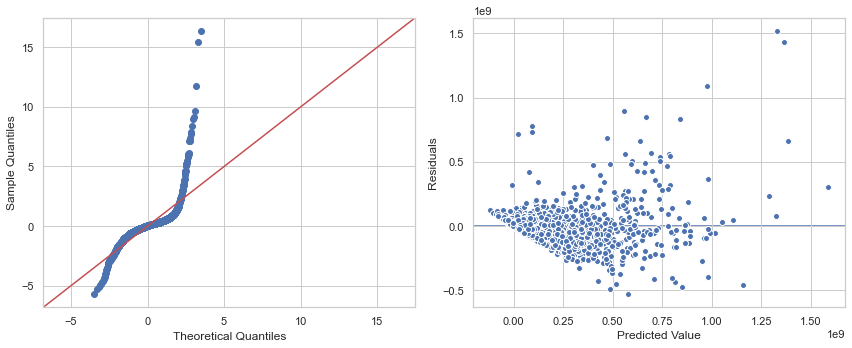

In [53]:
evaluate_ols(result,X_train_df, y_train)

## Removing features - based on p-values

In [54]:
## Get list of ALL genre columns to see how many are sig
p_vals = result.pvalues
p_vals[p_vals>.5]

year                                 0.600112
month                                0.942441
day                                  0.692510
certification_NC-17                  0.715537
certification_R                      0.871633
Genre_Drama                          0.778994
Genre_Horror                         0.787228
Genre_Comedy                         0.619991
Genre_War                            0.657161
ProdComp_BBC Films                   0.933603
ProdComp_Blumhouse Productions       0.901131
ProdComp_CJ Entertainment            0.625357
ProdComp_Canal+                      0.629675
ProdComp_Ciné+                       0.672520
ProdComp_Epsilon Motion Pictures     0.645288
ProdComp_EuropaCorp                  0.675651
ProdComp_Fox 2000 Pictures           0.729326
ProdComp_Fox Searchlight Pictures    0.784528
ProdComp_France 3 Cinéma             0.926835
ProdComp_New Line Cinema             0.991241
ProdComp_Original Film               0.990496
ProdComp_Participant              

In [55]:
## save just genre pvalues
# use a list comprehension to filter out column sthat start with zipcode
Genre_cols = [col for col in df.columns if col.startswith('Genre')]
## preview first few zipcode cols to confirm
Genre_cols[:3]

['Genre_Drama', 'Genre_Romance', 'Genre_Horror']

In [56]:
## calc what % are insig?

len(Genre_cols)

prod_cols = [col for col in df.columns if col.startswith('ProdComp')]
## preview first few zipcode cols to confirm
prod_cols[:3]
len(prod_cols)

50

In [57]:
len(p_vals[p_vals>.05])

56

In [58]:
#Adding to the list of columns to drop
drop_cols = drop_cols + prod_cols
drop_cols

['revenue',
 'title',
 'imdb_id',
 'prod_company',
 'production_companies',
 'ProdComp_20th Century Fox',
 'ProdComp_BBC Films',
 'ProdComp_Blumhouse Productions',
 'ProdComp_CJ Entertainment',
 'ProdComp_Canal+',
 'ProdComp_Ciné+',
 'ProdComp_Columbia Pictures',
 'ProdComp_Dimension Films',
 'ProdComp_DreamWorks Animation',
 'ProdComp_DreamWorks Pictures',
 'ProdComp_Dune Entertainment',
 'ProdComp_Epsilon Motion Pictures',
 'ProdComp_EuropaCorp',
 'ProdComp_Film4 Productions',
 'ProdComp_Focus Features',
 'ProdComp_Fox 2000 Pictures',
 'ProdComp_Fox Searchlight Pictures',
 'ProdComp_France 2 Cinéma',
 'ProdComp_France 3 Cinéma',
 'ProdComp_Ingenious Media',
 'ProdComp_Legendary Pictures',
 'ProdComp_Lionsgate',
 'ProdComp_MISSING',
 'ProdComp_Metro-Goldwyn-Mayer',
 'ProdComp_Millennium Films',
 'ProdComp_Miramax',
 'ProdComp_New Line Cinema',
 'ProdComp_New Regency Pictures',
 'ProdComp_Original Film',
 'ProdComp_Paramount',
 'ProdComp_Participant',
 'ProdComp_Regency Enterprises',
 

## Repeat Preprocessing but as a function

In [59]:
def preprocess (X, y):
    
    ## Dropping columns


    ## Make x and y variables
    y = y
    X = X

    X_train, X_test, y_train, y_test = train_test_split(X,y)#, random_state=321)


    ## make cat selector and using it to save list of column names
    cat_select = make_column_selector(dtype_include='object')
    cat_cols = cat_select(X_train)


    ## make num selector and using it to save list of column names
    num_select = make_column_selector(dtype_include='number')
    num_cols = num_select(X_train)


    ## select manually OHE cols for later
    bool_select = make_column_selector(dtype_include='bool')
    already_ohe_cols = bool_select(X_train)


    ## convert manual ohe to int
    X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
    X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

    ## make pipelines
    cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                           fill_value='MISSING'),
                             OneHotEncoder(handle_unknown='ignore', sparse=False))
    num_pipe = make_pipeline(SimpleImputer(strategy='mean'),#StandardScaler()
                            )

    preprocessor = make_column_transformer((num_pipe, num_cols),
                                           (cat_pipe,cat_cols),remainder='passthrough')

    ## fit the col transformer
    preprocessor.fit(X_train)

    ## Finding the categorical pipeline in our col transformer.
    preprocessor.named_transformers_['pipeline-2']

    ## B) Using list-slicing to find the encoder 
    cat_features = preprocessor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)


    ## Create the empty list
    final_features = [*num_cols,*cat_features,*already_ohe_cols]
    len(final_features)

    preprocessor.transform(X_train).shape

    X_train_tf = pd.DataFrame( preprocessor.transform(X_train), 
                              columns=final_features, index=X_train.index)


    X_test_tf = pd.DataFrame( preprocessor.transform(X_test),
                             columns=final_features, index=X_test.index)


    ### Adding a Constant for Statsmodels

    ##import statsmodels correctly
    import statsmodels.api as sm

    ## Make final X_train_df and X_test_df with constants added
    X_train_df = sm.add_constant(X_train_tf, prepend=False, has_constant='add')
    X_test_df = sm.add_constant(X_test_tf, prepend=False, has_constant='add')

    ## instantiate an OLS model WITH the training data.
    model = sm.OLS(y_train, X_train_df)
    ## Fit the model and view the summary
    result = model.fit()
    result.summary()

    

    print ('_______________________________________________')
    ## Get train data performance from skearn to confirm matches OLS
    y_hat_train = result.predict(X_train_df)
    print(f'Sklearn version| Training R^2: {r2_score(y_train, y_hat_train):.3f}')

    ## Get test data performance
    y_hat_test = result.predict(X_test_df)
    print(f'Sklearn version| Testing  R^2: {r2_score(y_test, y_hat_test):.3f}')
    
   
  

In [60]:
preprocess(X = df.drop(columns =drop_cols), y = df["revenue"])

_______________________________________________
Sklearn version| Training R^2: 0.679
Sklearn version| Testing  R^2: 0.690


### Linearity

In [61]:
## saving list of numeric features to slice for pairplot
num_selector = make_column_selector(dtype_include='number')
cols = num_selector(df.drop(columns='revenue'))
len(cols)

9

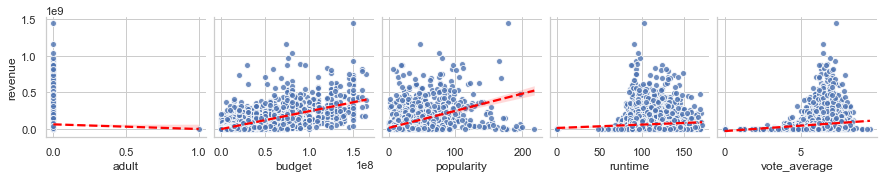

In [62]:
sns.pairplot(df, y_vars='revenue',x_vars=cols[:5], kind = "reg",plot_kws=dict(line_kws={'color':'red', 'ls':'--'},
                           scatter_kws={'edgecolor':'white','lw':1}) );

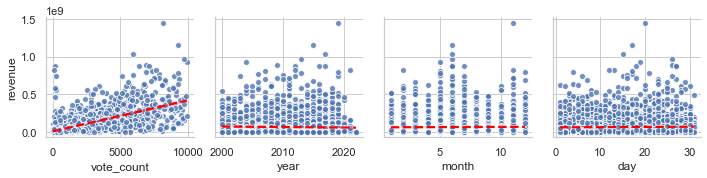

In [63]:
sns.pairplot(df, y_vars='revenue',x_vars=cols[5:9], kind = "reg",plot_kws=dict(line_kws={'color':'red', 'ls':'--'},
                           scatter_kws={'edgecolor':'white','lw':1}) );

In [93]:
cols = ["adult","year", "month", "day"]

In [94]:
drop_cols =drop_cols + cols
drop_cols

['revenue',
 'title',
 'imdb_id',
 'prod_company',
 'production_companies',
 'ProdComp_20th Century Fox',
 'ProdComp_BBC Films',
 'ProdComp_Blumhouse Productions',
 'ProdComp_CJ Entertainment',
 'ProdComp_Canal+',
 'ProdComp_Ciné+',
 'ProdComp_Columbia Pictures',
 'ProdComp_Dimension Films',
 'ProdComp_DreamWorks Animation',
 'ProdComp_DreamWorks Pictures',
 'ProdComp_Dune Entertainment',
 'ProdComp_Epsilon Motion Pictures',
 'ProdComp_EuropaCorp',
 'ProdComp_Film4 Productions',
 'ProdComp_Focus Features',
 'ProdComp_Fox 2000 Pictures',
 'ProdComp_Fox Searchlight Pictures',
 'ProdComp_France 2 Cinéma',
 'ProdComp_France 3 Cinéma',
 'ProdComp_Ingenious Media',
 'ProdComp_Legendary Pictures',
 'ProdComp_Lionsgate',
 'ProdComp_MISSING',
 'ProdComp_Metro-Goldwyn-Mayer',
 'ProdComp_Millennium Films',
 'ProdComp_Miramax',
 'ProdComp_New Line Cinema',
 'ProdComp_New Regency Pictures',
 'ProdComp_Original Film',
 'ProdComp_Paramount',
 'ProdComp_Participant',
 'ProdComp_Regency Enterprises',
 

## Checking performance of Model

In [65]:
preprocess(X = df.drop(columns =drop_cols), y = df["revenue"])

_______________________________________________
Sklearn version| Training R^2: 0.689
Sklearn version| Testing  R^2: 0.659


## Removing features - based on p-values

In [66]:
## Get list of ALL genre columns to see how many are sig
p_vals = result.pvalues
p_vals[p_vals>.5]

year                                 0.600112
month                                0.942441
day                                  0.692510
certification_NC-17                  0.715537
certification_R                      0.871633
Genre_Drama                          0.778994
Genre_Horror                         0.787228
Genre_Comedy                         0.619991
Genre_War                            0.657161
ProdComp_BBC Films                   0.933603
ProdComp_Blumhouse Productions       0.901131
ProdComp_CJ Entertainment            0.625357
ProdComp_Canal+                      0.629675
ProdComp_Ciné+                       0.672520
ProdComp_Epsilon Motion Pictures     0.645288
ProdComp_EuropaCorp                  0.675651
ProdComp_Fox 2000 Pictures           0.729326
ProdComp_Fox Searchlight Pictures    0.784528
ProdComp_France 3 Cinéma             0.926835
ProdComp_New Line Cinema             0.991241
ProdComp_Original Film               0.990496
ProdComp_Participant              

In [67]:
## save just genre pvalues
# use a list comprehension to filter out column sthat start with zipcode
Genre_cols = [col for col in df.columns if col.startswith('Genre')]
## preview first few zipcode cols to confirm
Genre_cols[:3]

## calc what % are insig?

['Genre_Drama', 'Genre_Romance', 'Genre_Horror']

In [68]:
len(Genre_cols)

18

In [69]:
prod_cols = [col for col in df.columns if col.startswith('ProdComp')]
## preview first few zipcode cols to confirm
prod_cols[:3]

['ProdComp_20th Century Fox',
 'ProdComp_BBC Films',
 'ProdComp_Blumhouse Productions']

In [70]:
len(prod_cols)

50

In [71]:
len(p_vals[p_vals>.05])

56

In [72]:
drop_cols = drop_cols + prod_cols
drop_cols

['revenue',
 'title',
 'imdb_id',
 'prod_company',
 'production_companies',
 'ProdComp_20th Century Fox',
 'ProdComp_BBC Films',
 'ProdComp_Blumhouse Productions',
 'ProdComp_CJ Entertainment',
 'ProdComp_Canal+',
 'ProdComp_Ciné+',
 'ProdComp_Columbia Pictures',
 'ProdComp_Dimension Films',
 'ProdComp_DreamWorks Animation',
 'ProdComp_DreamWorks Pictures',
 'ProdComp_Dune Entertainment',
 'ProdComp_Epsilon Motion Pictures',
 'ProdComp_EuropaCorp',
 'ProdComp_Film4 Productions',
 'ProdComp_Focus Features',
 'ProdComp_Fox 2000 Pictures',
 'ProdComp_Fox Searchlight Pictures',
 'ProdComp_France 2 Cinéma',
 'ProdComp_France 3 Cinéma',
 'ProdComp_Ingenious Media',
 'ProdComp_Legendary Pictures',
 'ProdComp_Lionsgate',
 'ProdComp_MISSING',
 'ProdComp_Metro-Goldwyn-Mayer',
 'ProdComp_Millennium Films',
 'ProdComp_Miramax',
 'ProdComp_New Line Cinema',
 'ProdComp_New Regency Pictures',
 'ProdComp_Original Film',
 'ProdComp_Paramount',
 'ProdComp_Participant',
 'ProdComp_Regency Enterprises',
 

### Checking the performance of the model 

In [73]:
preprocess(X = df.drop(columns =drop_cols), y = df["revenue"])

_______________________________________________
Sklearn version| Training R^2: 0.690
Sklearn version| Testing  R^2: 0.656


# Multicollinearity

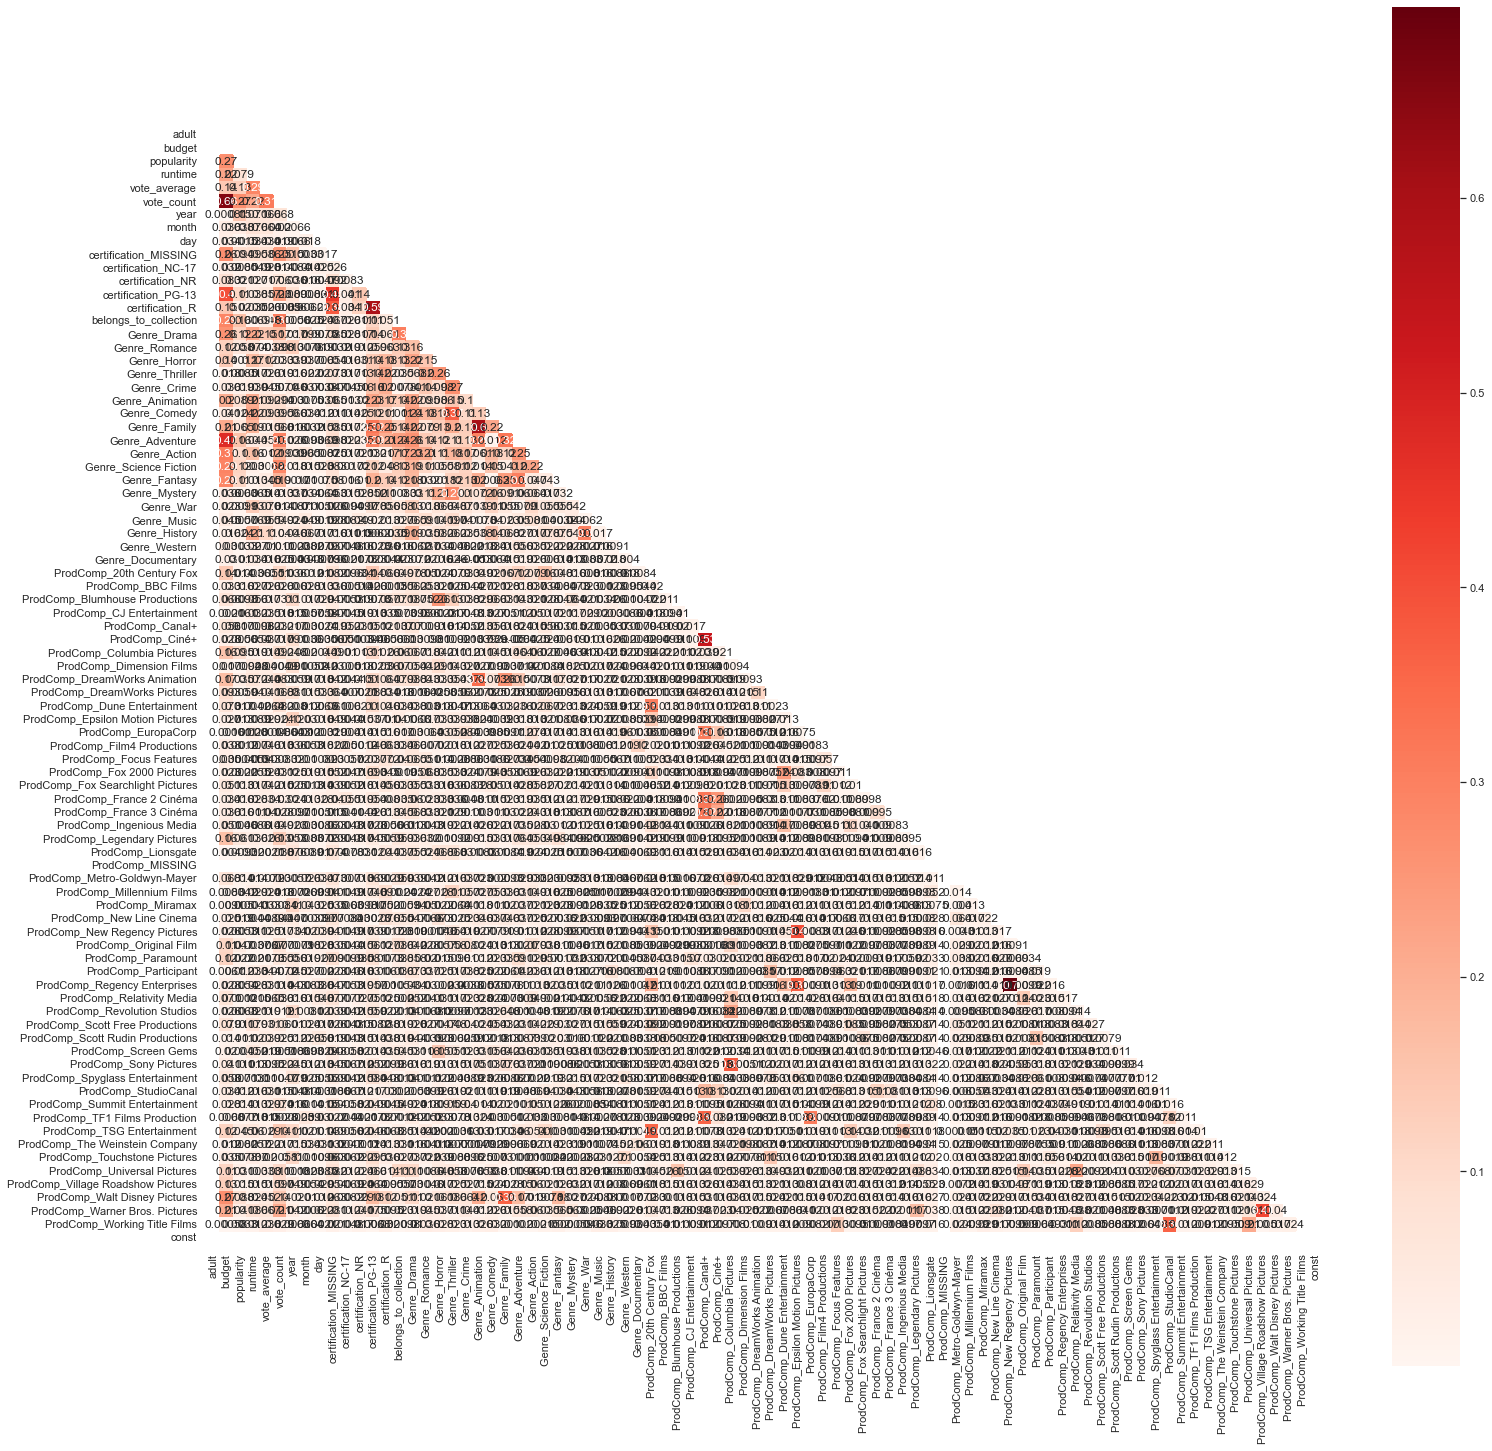

In [74]:
## Calculating the mask to hide the upper-right of the triangle
corr = X_train_df.corr().abs()

mask = np.triu(np.ones_like(corr))

plt.figure(figsize=(25,25))
sns.heatmap(corr,square=True, cmap='Reds', annot=True, mask=mask);

### Variance Inflation Factor

In [75]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
 
# separate just x-data and subtract mean

In [76]:
corr_matrix =df.corr().abs()

upper =corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any (upper[column]>0.50)]

C:\Users\heill\anaconda3\envs\dojo-env\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:
# create a list of VIF scores for each feature in features.
drop_cols = drop_cols + to_drop
# create a new dataframe to hold the VIF scores 

### Checking the performance of the model 

In [78]:
preprocess(X = df.drop(columns =drop_cols), y = df["revenue"])

_______________________________________________
Sklearn version| Training R^2: 0.571
Sklearn version| Testing  R^2: 0.632


## final Model after all tunning

In [95]:
 
    ## Make x and y variables
y = df["revenue"]
X = df.drop(columns=drop_cols)

X_train, X_test, y_train, y_test = train_test_split(X,y)#, random_state=321)


## make cat selector and using it to save list of column names
cat_select = make_column_selector(dtype_include='object')
cat_cols = cat_select(X_train)

In [80]:
## make num selector and using it to save list of column names
num_select = make_column_selector(dtype_include='number')
num_cols = num_select(X_train)

In [81]:
## select manually OHE cols for later
bool_select = make_column_selector(dtype_include='bool')
already_ohe_cols = bool_select(X_train)

In [82]:
## convert manual ohe to int
X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

In [83]:
## make pipelines
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                           fill_value='MISSING'),
                 OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

In [84]:
preprocessor = make_column_transformer((num_pipe, num_cols),
                           (cat_pipe,cat_cols),remainder='passthrough')

## fit the col transformer
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['adult', 'budget', 'popularity', 'runtime',
                                  'vote_average', 'vote_count', 'year', 'month',
                                  'day']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['certificati

In [96]:
## Finding the categorical pipeline in our col transformer.
preprocessor.named_transformers_['pipeline-2']

## B) Using list-slicing to find the encoder 
cat_features = preprocessor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)

In [97]:
## Create the empty list
final_features = [*num_cols,*cat_features,*already_ohe_cols]
len(final_features)

83

In [98]:
preprocessor.transform(X_train).shape

ValueError: columns are missing: {'ProdComp_Summit Entertainment', 'ProdComp_Scott Free Productions', 'ProdComp_Lionsgate', 'ProdComp_Film4 Productions', 'ProdComp_Epsilon Motion Pictures', 'ProdComp_EuropaCorp', 'ProdComp_The Weinstein Company', 'ProdComp_Blumhouse Productions', 'ProdComp_StudioCanal', 'ProdComp_Universal Pictures', 'ProdComp_Legendary Pictures', 'ProdComp_New Line Cinema', 'ProdComp_Original Film', 'ProdComp_Working Title Films', 'ProdComp_Paramount', 'ProdComp_MISSING', 'ProdComp_BBC Films', 'ProdComp_Warner Bros. Pictures', 'ProdComp_Ciné+', 'ProdComp_Sony Pictures', 'ProdComp_Millennium Films', 'ProdComp_Canal+', 'ProdComp_TF1 Films Production', 'ProdComp_Regency Enterprises', 'ProdComp_20th Century Fox', 'ProdComp_TSG Entertainment', 'ProdComp_CJ Entertainment', 'ProdComp_Miramax', 'ProdComp_Walt Disney Pictures', 'ProdComp_Dune Entertainment', 'ProdComp_Dimension Films', 'ProdComp_Touchstone Pictures', 'ProdComp_DreamWorks Pictures', 'ProdComp_Fox Searchlight Pictures', 'ProdComp_Revolution Studios', 'ProdComp_New Regency Pictures', 'ProdComp_Screen Gems', 'ProdComp_Scott Rudin Productions', 'ProdComp_France 2 Cinéma', 'ProdComp_Ingenious Media', 'ProdComp_France 3 Cinéma', 'ProdComp_Spyglass Entertainment', 'ProdComp_DreamWorks Animation', 'ProdComp_Metro-Goldwyn-Mayer', 'ProdComp_Columbia Pictures', 'ProdComp_Participant', 'ProdComp_Village Roadshow Pictures', 'Genre_Family', 'ProdComp_Fox 2000 Pictures', 'ProdComp_Relativity Media', 'ProdComp_Focus Features'}

In [88]:
X_train_tf = pd.DataFrame( preprocessor.transform(X_train), 
                          columns=final_features, index=X_train.index)


X_test_tf = pd.DataFrame( preprocessor.transform(X_test),
                             columns=final_features, index=X_test.index)

In [89]:
### Adding a Constant for Statsmodels

##import statsmodels correctly
import statsmodels.api as sm

    #> Tip: make sure that add_constant actually added a new column! You may need to change the parameter has_constant to "add"

## Make final X_train_df and X_test_df with constants added
X_train_df = sm.add_constant(X_train_tf, prepend=False, has_constant='add')
X_test_df = sm.add_constant(X_test_tf, prepend=False, has_constant='add')

In [90]:
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
result.summary() 
    
    
   

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     163.5
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:20:09   Log-Likelihood:                -75020.
No. Observations:                3808   AIC:                         1.502e+05
Df Residuals:                    3726   BIC:                         1.507e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
adult                               9.847e+06   8.82e+07      0.112      0.911   -1.63e+08    1.83e+08
budget                                 1.8240      0.055     33.264      0.000       1.717       1.932
popularity                          1.587e+05   1.34e+04     11.833      0.000    1.32e+05    1.85e+05
runtime                             2.388e+05   8.19e+04      2.916      0.004    7.83e+04    3.99e+05
vote_average                       -2.468e+06   1.41e+06     -1.753      0.080   -5.23e+06    2.93e+05
vote_count                           2.77e+04    637.877     43.427      0.000    2.65e+04     2.9e+04
year                                2.213e+05    2.8e+05      0.791      0.429   -3.27e+05     7.7e+05
month                               -5.73e+05   4.22e+05     -1.357      0.175    -1.4e+06    2.55e+05
day                                 5.366e+04   1.69e+05      0.318      0.750   -2.77e+05    3.84e+05
certification_MISSING              -6.786e+07   9.42e+07     -0.721      0.471   -2.52e+08    1.17e+08
certification_NC-17                -7.743e+07   9.63e+07     -0.804      0.421   -2.66e+08    1.11e+08
certification_NR                   -7.405e+07   9.42e+07     -0.786      0.432   -2.59e+08    1.11e+08
certification_PG-13                -7.362e+07   9.36e+07     -0.787      0.432   -2.57e+08     1.1e+08
certification_R                    -9.336e+07   9.36e+07     -0.998      0.318   -2.77e+08    9.01e+07
belongs_to_collection               4.687e+07   3.93e+06     11.919      0.000    3.92e+07    5.46e+07
Genre_Drama                        -5.144e+06   3.74e+06     -1.375      0.169   -1.25e+07    2.19e+06
Genre_Romance                       1.801e+06   4.21e+06      0.428      0.669   -6.44e+06       1e+07
Genre_Horror                       -3.514e+06   5.62e+06     -0.625      0.532   -1.45e+07    7.51e+06
Genre_Thriller                     -6.242e+06      4e+06     -1.559      0.119   -1.41e+07    1.61e+06
Genre_Crime                        -4.551e+06   4.56e+06     -0.998      0.318   -1.35e+07    4.39e+06
Genre_Animation                     1.419e+07   7.94e+06      1.786      0.074   -1.38e+06    2.98e+07
Genre_Comedy                       -2.271e+06   3.75e+06     -0.605      0.545   -9.63e+06    5.09e+06
Genre_Family                       -1.519e+07   6.55e+06     -2.319      0.020    -2.8e+07   -2.35e+06
Genre_Adventure                     9.403e+06   4.83e+06      1.948      0.052   -6.13e+04    1.89e+07
Genre_Action                       -1.058e+07   4.01e+06     -2.642      0.008   -1.84e+07   -2.73e+06
Genre_Science Fiction              -3.806e+07   5.39e+06     -7.065      0.000   -4.86e+07   -2.75e+07
Genre_Fantasy                      -1.408e+07   5.26e+06     -2.680      0.007   -2.44e+07   -3.

In [91]:
    print ('_______________________________________________')
    ## Get train data performance from skearn to confirm matches OLS
    y_hat_train = result.predict(X_train_df)
    print(f'Sklearn version| Training R^2: {r2_score(y_train, y_hat_train):.3f}')

    ## Get test data performance
    y_hat_test = result.predict(X_test_df)
    print(f'Sklearn version| Testing  R^2: {r2_score(y_test, y_hat_test):.3f}')
    

_______________________________________________
Sklearn version| Training R^2: 0.780
Sklearn version| Testing  R^2: 0.717


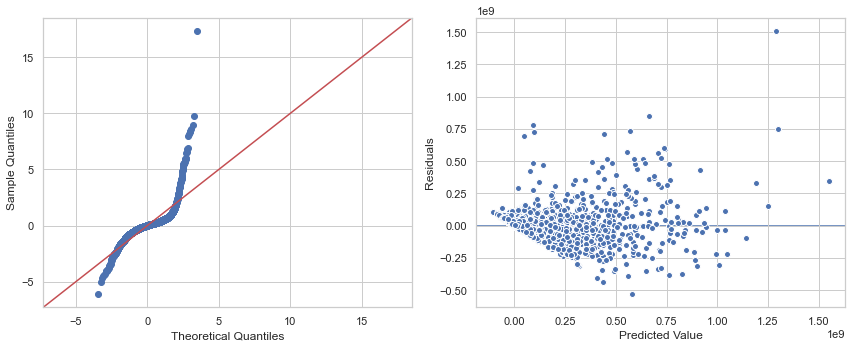

In [92]:
 
evaluate_ols(result,X_train_df, y_train)